In [1]:
# Plot the loss curve for the XOR problem using non-orthogonal encoding
from pennylane import numpy as np
from matplotlib import pyplot as plt
import pennylane as qml

In [2]:
# We define a device with three qubits
dev = qml.device('default.qubit', wires=3)

# Define the quantum function 
@qml.qnode(dev)
def qnn(params, state, label=0, type='indi'):
    # Prepare the initial state
    if type == 'indi':
        if state is not None:
            qml.QubitStateVector(state, wires=0)
    elif type == 'super':
        if state is not None:
            qml.QubitStateVector(state, wires=range(3))
    # U3 gate on initial state
    qml.Rot(params[0], params[1], params[2], wires=0)
    # Apply the rotation gates
    qml.CRY(params[3], wires=[0, 1])
    qml.RY(params[4], wires=1)
    if label==1:
        qml.PauliX(wires=2)
    
    # Return the expectation value of Z
    return qml.expval(qml.PauliZ(1) @ qml.PauliZ(2))

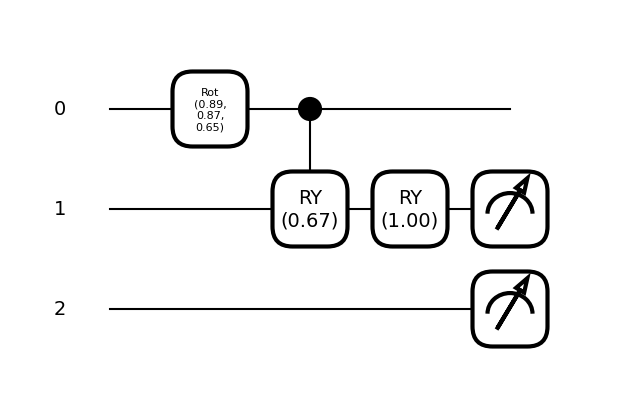

In [3]:
# Random initialization of parameters
params_init = np.random.rand(5)

# Draw the executed quantum circuit:
fig, ax = qml.draw_mpl(qnn, decimals=2)(params_init, state=None)
plt.show()

In [4]:
# Loss function
def loss(results):
    return -np.sum(results)/4 

# Data: 00, 01, 10, 11 
# Tetrahedron in a bloch sphere
states = [np.array([1, 0]), 
          np.array([np.sqrt(1/3), np.sqrt(2/3)]),
          np.array([1j*np.sqrt(1/3), 1j*np.sqrt(2/3) * np.exp(1j*4*np.pi/3)]),
          np.array([np.sqrt(1/3), np.sqrt(2/3) * np.exp(1j*2*np.pi/3)])] 

labels = np.array([0, 1, 1, 0])  # class labels

In [5]:
# Set up the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.1)
loss_i = []

# Training
params = params_init
for i in range(300):
    # Compute the predictions
    results = np.array([qnn(params, state, label) 
                            for (state, label) in zip (states, labels)])
    current_loss = loss(results)
    loss_i.append(current_loss)
    # Update the parameters
    params = opt.step(lambda p: loss(np.array([qnn(p, state=state, label=label) 
                                        for (state, label) in zip (states, labels)])), 
                                        params)

# Print out the final parameters
print(f"Final parameters: {params}")

Final parameters: [1.04719281 0.9553166  0.64741828 3.04889359 0.05730424]


In [6]:
# Loss function
def loss_super(results):
    return -np.sum(results)

state = np.array([states[0][0]+states[3][0],
                  states[1][0]+states[2][0],
                  0,
                  0,
                  states[0][1]+states[3][1],
                  states[1][1]+states[2][1],
                  0,
                  0])

state_super = state / np.linalg.norm(state)

In [7]:
loss_sup_test = []
loss_sup_train = []

# Tarining
params_s = params_init
for i in range(300):
    # Compute the predictions
    results = np.array([qnn(params_s, state=state, label=label) 
                            for (state, label) in zip (states, labels)])
    current_loss = loss(results)
    loss_sup_test.append(current_loss)
    loss_sup_train.append(loss_super(qnn(params_s, state=state_super, type='super')))

    # Update the parameters
    params_s = opt.step(lambda p: loss_super(qnn(p, state=state_super, type='super')),
                        params_s)
    
# Print out the final parameters
print(f"Final parameters: {params_s}")
np.save('params_nonortho.npy', params_s)  # Saves the array to a file

Final parameters: [1.04719755 0.95531662 0.64741828 3.13364428 0.00491237]


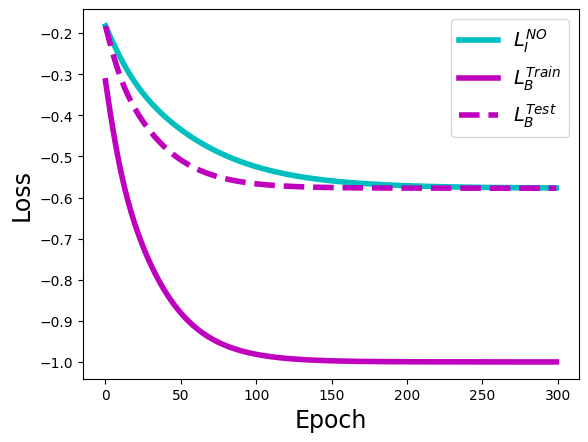

In [8]:
plt.figure().add_subplot()
plt.xlabel('Epoch', fontsize=17)
plt.ylabel('Loss', fontsize=17)
plt.plot(np.array(loss_i).T, color='c', linewidth=4,label='$L_I^{NO}$')
plt.plot(np.array(loss_sup_train).T, color='m', linewidth=4,label='$L_B^{Train}$')
plt.plot(np.array(loss_sup_test).T, color='m', linewidth=4,label='$L_B^{Test}$', linestyle='--')
plt.legend(fontsize=14)